# 飞桨常规赛：PALM病理性近视病灶检测与分割 - 5月第六名方案
截至目前一共就6个人提交了，高情商：第六名，低情商：最后一名。虽然我是渣渣，但也想有大佬帮忙看看这样做的问题（不是这个项目，这个是分开训练常规训练的两个模型分别预测）。此方案仅用于交差，没啥参考和讨论的价值。

欢迎移步这个分更低的项目讨论：

[飞桨常规赛：PALM病理性近视病灶检测与分割](https://aistudio.baidu.com/aistudio/projectdetail/1900766)

# 0. 赛题介绍
常规赛：PALM病理性近视病灶检测与分割由ISBI2019 PALM眼科挑战赛赛题再现，其中病理性近视病灶检测与分割的任务旨在对眼科图像进行判断，获取两种疾病的分割结果。

数据集由中山大学中山眼科中心提供800张带萎缩和脱离病变分割标注的眼底彩照供选手训练模型，另提供400张带标注数据供平台进行模型测试。图像分辨率为1444×1444，或2124×2056。标注金标准存储为BMP图像。分割图像大小与对应的眼底图像大小相同，标签如下:
1. 萎缩病变分割金标准：萎缩区域：0；背景：255；
2. 脱离病变分割金标准：脱离区域：0；背景：255。

评价指标为：0.5 X F1分数 + 0.5 X Dice

![](https://ai-studio-static-online.cdn.bcebos.com/7e9182302d6d498e953b130ef7a8d0fd22f7576f92fd44c8afc9b7236c380b0f)

比赛链接: [常规赛：PALM病理性近视病灶检测与分割](https://aistudio.baidu.com/aistudio/competition/detail/88)

# 1. 包准备
既然是分割任务，首先想到的是PaddleSeg。那就直接搞起来就对了。这里想到之前遥感分割中用到patta还挺不错的，这里也弄进来一起搅。

In [1]:
# ! git clone https://gitee.com/paddlepaddle/PaddleSeg.git
! pip -q install patta

import sys

sys.path.append('PaddleSeg')

## 2. 数据准备
### 2.1解压数据集
这个没啥好写的。

In [2]:
# ! unzip -oq /home/aistudio/data/data85135/常规赛：PALM病理性近视病灶检测与分割.zip
# ! rm -rf __MACOSX
# ! mv 常规赛：PALM病理性近视病灶检测与分割 dataset

### 2.2 生成数据列表
老套路了，这里按0.9进行划分的，0.9的训练数据，0.1的验证数据。只是这里将两个数据分开进行处理，分别生成数据列表。这里我做点改变就是针对有一个任务标签很少的情况，每当读到它有标签的图像，就写50次进来，希望正负样本可以更加均衡。

In [4]:
import os
import random

def create_list(lab_class='Detachment', s_rate=9, ex_num=50):
    file_path = 'dataset/Train/fundus_image'
    imgs_name = os.listdir(file_path)
    random.shuffle(imgs_name)
    with open('dataset/Train/' + lab_class + '_train.txt', 'w') as tf:
        with open('dataset/Train/' + lab_class + '_val.txt', 'w') as ef:
            for idx, img_name in enumerate(imgs_name):
                img_path = os.path.join('fundus_image', img_name)
                lab_path = img_exist('dataset/Train', \
                					 img_path.replace('fundus_image', ('Lesion_Masks/' + \
                                     lab_class)).replace('jpg', 'bmp'))
                if (idx % 10 + 1) < s_rate:
                    if lab_class == 'Detachment' and lab_path != 'None':
                        for _ in range(ex_num):
                            tf.write(img_path + ' ' + lab_path + '\n')
                    else:
                    	tf.write(img_path + ' ' + lab_path + '\n')
                else:
                    ef.write(img_path + ' ' + lab_path + '\n')

def img_exist(path, name):
    p = os.path.join(path, name)
    if os.path.exists(p):
        return name
    else:
        return 'None'

def shuffle_txt(path, save_path):
    out = open(save_path,'w')
    lines = []
    with open(path, 'r') as infile:
        for line in infile:
            lines.append(line)
        random.shuffle(lines)
        for line in lines:
            out.write(line)
    out.close()

# create_list('Detachment', s_rate=8)
# create_list('Atrophy')
# shuffle_txt('dataset/Train/Detachment_train.txt', \
# 		   'dataset/Train/Detachment_train_shuffle.txt')

### 2.3 构建数据集
构建数据集也是套路的seg的方案，只是也是分别进行了处理。

In [2]:
from paddleseg.datasets import Dataset
import paddleseg.transforms as T

# 构建训练集
train_transforms = [
    T.RandomHorizontalFlip(),  # 水平翻转
    T.RandomRotation(),  # detachment
    T.Resize(target_size=(1024, 1024)),  # 修改大小
    T.Normalize()  # 归一化
]

d_train_dataset = Dataset(
    transforms=train_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='train',
    train_path='dataset/Train/Detachment_train_shuffle.txt',
    separator=' ',
)

a_train_dataset = Dataset(
    transforms=train_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='train',
    train_path='dataset/Train/Atrophy_train.txt',
    separator=' ',
)

# 构建验证集
val_transforms = [
    T.Resize(target_size=(1024, 1024)),
    T.Normalize()
]

d_val_dataset = Dataset(
    transforms=val_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='val',
    val_path='dataset/Train/Detachment_val.txt',
    separator=' ',
)

a_val_dataset = Dataset(
    transforms=val_transforms,
    dataset_root='dataset/Train',
    num_classes=2,
    mode='val',
    val_path='dataset/Train/Atrophy_val.txt',
    separator=' ',
)

这里也是输出测试一下，看看数据读取有没有什么问题。避免后面报一堆错不知道哪儿去找问题。还可以看看图像是否正确。

In [6]:
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt

# %matplotlib inline

# for img, lab in d_train_dataset:
#     print(img.shape, lab.shape)
#     plt.subplot(121);plt.imshow(img.transpose((1, 2, 0)))
#     plt.subplot(122);plt.imshow(lab)
#     plt.show()
#     break

## 3. 模型训练
### 3.1 训练准备
这里选了一个我从来没用过的网路SFNet，不过有一次就会有下一次，所以就尝试下没用过的。损失混合了三种损失，两个任务需要分别进行训练。

In [7]:
import paddle
from paddleseg.models import SFNet
from paddleseg.models.backbones import ResNet50_vd
from paddleseg.models.losses import BCELoss, DiceLoss, LovaszHingeLoss, MixedLoss

# 模型
url = 'a_save_output/best_model/model.pdparams'
model = SFNet(num_classes=2, backbone=ResNet50_vd(output_stride=8), \
			  backbone_indices=[0, 1, 2, 3], pretrained=url)
# 训练参数
epochs = 10
batch_size = 4
iters = epochs * len(d_train_dataset) // batch_size
# 损失函数
mix_losses = [BCELoss(), DiceLoss(), LovaszHingeLoss()]
mix_coef = [1, 1, 1]
mixloss = MixedLoss(mix_losses, mix_coef)
losses = {}
losses['types'] = [mixloss]
losses['coef'] = [1]
# 学习率及优化器
base_lr = 3e-4
# lr = paddle.optimizer.lr.CosineAnnealingDecay(base_lr, T_max=(iters // 5))
lr = paddle.optimizer.lr.PolynomialDecay(base_lr, 4277 // 2, end_lr=3e-8)
optimizer = paddle.optimizer.Adam(lr, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-9))

2021-05-24 18:50:46 [INFO]	No pretrained model to load, ResNet_vd will be trained from scratch.
2021-05-24 18:50:46 [INFO]	Loading pretrained model from a_save_output/best_model/model.pdparams
2021-05-24 18:50:47 [INFO]	There are 354/354 variables loaded into SFNet.


### 3.2 模型训练
分别调用train即可。

In [8]:
from paddleseg.core import train

# train(
#     model=model,
#     train_dataset=d_train_dataset,
#     val_dataset=d_val_dataset,
#     optimizer=optimizer,
#     save_dir='d_save_output',
#     iters=iters,
#     batch_size=batch_size,
#     save_interval=int(iters / 10),
#     log_iters=10,
#     num_workers=0,
#     losses=losses,
#     use_vdl=True)

## 4. 模型预测
预测这里主要是两个问题。
1. 由于图像缩小到了1120，所以预测得到的结果需要resize到原大小才行。
2. 不知道是不是图像太大的问题，一使用patta就GPU炸了，所以这里的结果是没用TTA的结果。

In [3]:
import paddle
from paddleseg.models import SFNet
from paddleseg.models.backbones import ResNet50_vd
import paddleseg.transforms as T
from paddleseg.core import infer
import os
import cv2
from tqdm import tqdm
from PIL import Image
import numpy as np
import patta as tta

def nn_infer(model, model_path, imgs_path, class_name='Atrophy', is_tta=True):
    params = paddle.load(model_path)
    model.set_dict(params)
    model.eval()
    if not os.path.exists('Lesion_Segmentation'):
        os.mkdir('Lesion_Segmentation')
    if not os.path.exists(os.path.join('Lesion_Segmentation', class_name)):
        os.mkdir(os.path.join('Lesion_Segmentation', class_name))
    # 预测结果
    transforms = T.Compose([
        T.Resize(target_size=(1024, 1024)),
        T.Normalize()
    ])
    # 循环预测和保存
    for img_path in tqdm(imgs_path):
        H, W, _ = np.asarray(Image.open(img_path)).shape
        img, _ = transforms(img_path)  # 进行数据预处理
        img = paddle.to_tensor(img[np.newaxis, :])  # C,H,W -> 1,C,H,W
        # TTA
        if is_tta == True:
            tta_pres = paddle.zeros([1, 2, 1024, 1024])
            for tta_transform in tta.aliases.flip_transform():
                tta_img = tta_transform.augment_image(img)  # TTA_transforms
                tta_pre = infer.inference(model, tta_img)  # 预测
                deaug_pre = tta_transform.deaugment_mask(tta_pre)
                tta_pres += deaug_pre
            pre = tta_pres / 2.
        else:
            pre = infer.inference(model, img)  # 预测
        pred = paddle.argmax(pre, axis=1).numpy().reshape((1024, 1024)).astype('uint8') * 255
        pred = cv2.resize(pred, (W, H), interpolation=cv2.INTER_NEAREST)
        pil_img = Image.fromarray(pred)
        pil_img.save(os.path.join(('Lesion_Segmentation/' + class_name), img_path.split('/')[-1].replace('jpg', 'png')), 'png')

# 网络准备
a_model_path='a_save_output/best_model/model.pdparams'
d_model_path='d_save_output/best_model/model.pdparams'
model = SFNet(num_classes=2, backbone=ResNet50_vd(output_stride=8), \
			  backbone_indices=[0, 1, 2, 3], pretrained=None)
# 预测文件
set_path = 'dataset/PALM-Testing400-Images'
names = os.listdir(set_path)
imgs_path = []
for name in names:
    imgs_path.append(os.path.join(set_path, name))
# 预测
nn_infer(model, a_model_path, imgs_path, class_name='Atrophy', is_tta=False)
nn_infer(model, d_model_path, imgs_path, class_name='Detachment', is_tta=False)

2021-05-31 14:00:22 [INFO]	No pretrained model to load, ResNet_vd will be trained from scratch.


  0%|          | 0/400 [00:00<?, ?it/s]/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
100%|██████████| 400/400 [02:29<00:00,  2.67it/s]


## 5. 结果展示
可以用matplotlib显示一下分割的结果看看。

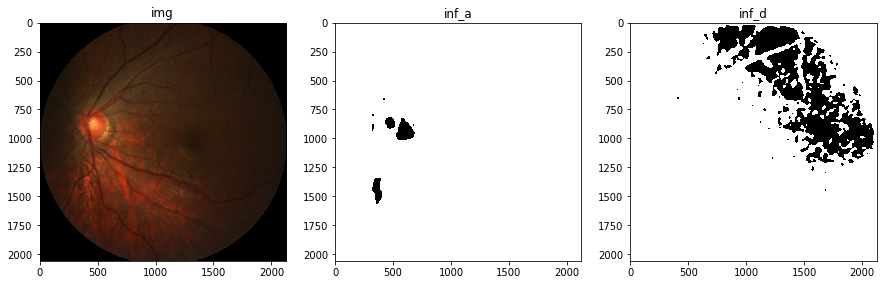

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

img_path = 'dataset/PALM-Testing400-Images/T0225.jpg'
inf_a_path = 'Lesion_Segmentation/Atrophy/T0225.png'
inf_d_path = 'Lesion_Segmentation/Detachment/T0225.png'
img = Image.open(img_path)
inf_a = Image.open(inf_a_path)
inf_d = Image.open(inf_d_path)
plt.figure(figsize=(15, 5))
plt.subplot(131);plt.imshow(img);plt.title('img')
plt.subplot(132);plt.imshow(inf_a);plt.title('inf_a')
plt.subplot(133);plt.imshow(inf_d);plt.title('inf_d')
plt.show()

## 心得
这里的心得主要在说[飞桨常规赛：PALM病理性近视病灶检测与分割](https://aistudio.baidu.com/aistudio/projectdetail/1900766)这个项目，因为其中带了我的思考
1. 这个任务要进行两个结果的分割，最开始我想能不能用一个网络搞定，用一个特征提取模块提取眼睛的特征，然后分别用两个解码网络来获取Atrophy和Detachment的分割结果。但是效果并不好，可能是有一个类别的样本实在太不均衡了，特征提取就关注样本均衡的那个类别去了（我猜
2. 由于他们都有存在没有标签的全负样本，所以我也想了在特征提取段接上两个FC进行分类，判断有没有特征。这样分类加分割一共四个数据进行一次性处理，四个loss，但结果Detachment的差的可怜。

所以我在想针对这种两个类别的样本数差异很大的多分割的任务，能不能使用一个网络进行训练？直接分割的效果更好还是加上分类判断后再分割的效果更好？以及样本不均衡可以用哪些方法来解决？希望懂的朋友可以交流下，官方那几篇论文估计还得看看。

## *参考及后续参考资料
1. [PaddleSeg](https://gitee.com/paddlepaddle/PaddleSeg)
2. [Patta](https://github.com/AgentMaker/PaTTA)

病理性近视病灶检测与分割相关论文
1. [Lesion-Aware Segmentation Network for Atrophy and Detachment of Pathological Myopia on Fundus Images](https://ieeexplore.ieee.org/abstract/document/9098669)
2. [Pathological myopia classification with simultaneous lesion segmentation using deep learning](https://arxiv.org/abs/2006.02813)
3. [Automatic lesion segmentation and Pathological Myopia classification in fundus images](https://arxiv.org/abs/2002.06382)